## Title: Predicting Customer Churn - A Machine Learning Approach

Description: Customer attrition, also known as customer churn, is a critical challenge faced by businesses. The goal of this project is to develop a predictive model that can identify customers who are likely to churn, allowing the organization to implement targeted retention strategies and reduce customer churn rate. By understanding the key factors that influence customer churn, we aim to provide valuable insights that will help the company make informed decisions to improve customer retention and loyalty


#### Step 1 and 2 - Install pyodbc and python-dotenv

In [1]:
%pip install pyodbc  
%pip install python-dotenv 
%pip install openpyxl
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Step 3 - Import all the necessary packages

In [2]:
import pyodbc #just installed with pip
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import openpyxl
import warnings 

warnings.filterwarnings('ignore')


## Data Loading

In [ ]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [ ]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [ ]:
# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query = "Select * from dbo.LP2_Telco_churn_first_3000"
data = pd.read_sql(query, connection)

## Hypothesis 

Customers on month-to-month contracts are more likely to churn compared to those on one-year or two-year contracts.

**Questions:**

1. Is there a relationship between the type of internet service (DSL, Fiber Optic, No Internet) and customer churn?
2. Does the monthly charge amount impact customer churn rate? Are higher monthly charges associated with higher churn?
3. Do customers who have additional services like online security, tech support, etc., have lower churn rates?
4. Is there a correlation between the tenure (number of months a customer has stayed with the company) and the likelihood of churn? Do customers who have been with the company for a longer time exhibit lower churn rates?
5. How does the payment method influence customer churn? Are customers using automatic payment methods (Electronic check, Bank transfer(automatic), Credit card(automatic)) less likely to churn compared to those using manual methods (mailed check)?




## Exploratory Data Analysis

In the exploratory data analysis phase, we will perform univariate, bivariate, and multivariate analysis to gain insights into the data. Visualizations such as bar charts, histograms, scatter plots, and correlation matrices will be used to understand the distribution of variables, relationships between features, and their impact on customer churn.

In [ ]:
data.head()

In [ ]:
data.info()

In [3]:
data2 = pd.read_excel("Telco-churn-second-2000.xlsx")
data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [4]:
data3 = pd.read_csv("LP2_Telco-churn-last-2000.csv")
data3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [5]:
# You can concatenate this with other DataFrames to get one data set for your work
# !!!Concatenation done for only data2 and data3

df = pd.concat([data2, data3])
df.to_csv('aba.csv')

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,NaN
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8,NaN
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55,NaN
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,...,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55,NaN
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15,NaN


Check the shapes of the dataframes

In [7]:
data2.shape

(2000, 20)

In [8]:
data3.shape

(2043, 21)

In [9]:
df.shape

(4043, 21)

In [10]:
df.head().T

,0,1,2,3,4
customerID,7613-LLQFO,4568-TTZRT,9513-DXHDA,2640-PMGFL,3801-HMYNL
gender,Male,Male,Male,Male,Male
SeniorCitizen,0,0,0,0,0
Partner,No,No,No,No,Yes
Dependents,No,No,No,Yes,Yes
tenure,12,9,27,27,1
PhoneService,Yes,Yes,Yes,Yes,Yes
MultipleLines,Yes,No,No,Yes,No
InternetService,Fiber optic,No,DSL,Fiber optic,Fiber optic
OnlineSecurity,No,No internet service,Yes,No,No


## Potential Data Issues with attempted solutions

1. Missing Values: We will check for missing values in the dataset and decide how to handle them. If there are only a few missing values, we may choose to drop those rows. If a significant number of records have missing values, we can consider imputation techniques like mean, median, or mode.

2. Data Types: We will ensure that the data types of each column are appropriate for the analysis. Categorical variables should be encoded as numeric values, and continuous variables should remain as numeric.

3. Class Imbalance: We need to check for class imbalance in the target variable (Churn). If there is a severe class imbalance, we may need to address it using techniques such as oversampling, undersampling, or using appropriate evaluation metrics.

4. Feature Scaling: Some machine learning algorithms may require feature scaling to ensure that all features contribute equally to the model. We will scale the numerical features if necessary.

5. Handling Categorical Variables: We will use one-hot encoding to convert categorical variables into a binary form suitable for model training.

6. Data Splitting: Before model training, we will split the data into training and testing sets to evaluate the model's performance on unseen data.

By addressing these issues during data preprocessing, we can ensure that our dataset is ready for model building and analysis.


In [11]:
# We start with Data Types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [12]:
# We expect Total Charges column be numeric, as it contains the total amount of money the client was charged/ 
# so it should not be an object.
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [13]:
# We notice that the column names don’t follow the same naming convention /n
# Some of them start with a lower letter and some upper. Let's make all of them uniform

df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [14]:
# Currently, it’s categorical, with two values, “yes” and “no”. For binary classification, \n 
# all models typically expect a number: 0 for “no” and 1 for “yes.” Let’s convert it to numbers.

df.churn = (df.churn == 'yes').astype(int)

In [15]:
# Missing Values
df.isnull().sum()

customerid             0
gender                 0
seniorcitizen          0
partner                0
dependents             0
tenure                 0
phoneservice           0
multiplelines          0
internetservice        0
onlinesecurity         0
onlinebackup           0
deviceprotection       0
techsupport            0
streamingtv            0
streamingmovies        0
contract               0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges        1997
churn                  0
dtype: int64

In [16]:
# From the above totalcharges column contains missing values of 1997. We fill missing values with 0
df.totalcharges = df.totalcharges.fillna(0)

In [17]:
df['churn'].dtype

dtype('int64')

In [18]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                 int64
dtype: object

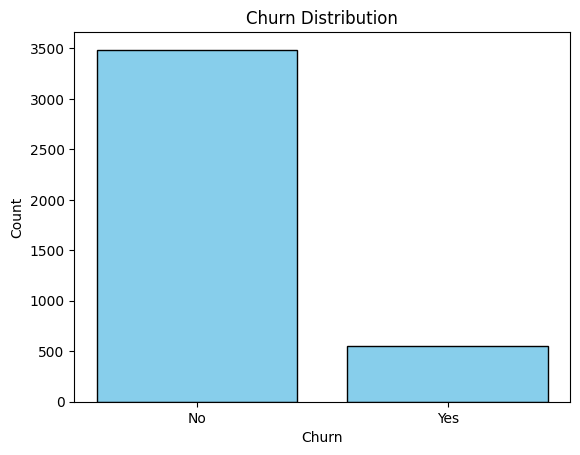

In [19]:
# Dealing with Class Imbalance
# Count the occurrences of each class in the 'Churn' column
churn_counts = df['churn'].value_counts()

# Plot the churn distribution as a bar chart to view the imbalance distribution in numberical terms
plt.bar(churn_counts.index, churn_counts.values, color='skyblue', edgecolor='k')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Churn Distribution')
plt.xticks([0, 1], ['No', 'Yes'])  # If churn values are 0 and 1, otherwise adjust accordingly
plt.show()

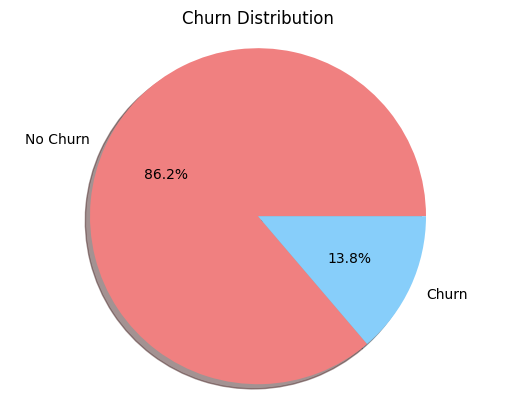

In [20]:
## Using a pie chart to view the above imbalance in percentage terms
# Plot the churn distribution as a pie chart
plt.pie(churn_counts, labels=['No Churn', 'Churn'], colors=['lightcoral', 'lightskyblue'], autopct='%1.1f%%', shadow=True)
plt.title('Churn Distribution')
plt.axis('equal')
plt.show()

In [21]:
df['churn'].value_counts().sum()

4043

###### From the above approximately 13.8% of the customers stopped using our services, and the rest remained as customers out of a total of 4,043 (this is based on the combined data2 and data3). For the class imbalance there is no need to effect any changes

In [22]:
# Handling Categorical Variables
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
'phoneservice', 'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'contract', 'paperlessbilling', 'paymentmethod']

In [ ]:
# We need to view the number of unique values in each categorical column
df[categorical].nunique()

In [23]:
global_churn_mean=df.churn.mean()

In [24]:
df_group = df.groupby(by='gender').churn.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_churn_mean
df_group['risk'] = df_group['mean'] / global_churn_mean
df_group

,mean,diff,risk
gender,,,
female,0.136790,-0.000732,0.994681
male,0.138256,0.000734,1.005338


In [25]:
for col in categorical:
    df_group = df.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_churn_mean
    df_group['rate'] = df_group['mean'] / global_churn_mean
display(df_group)

,mean,diff,rate
paymentmethod,,,
bank_transfer_(automatic),0.088681,-0.048840,0.644854
credit_card_(automatic),0.089017,-0.048504,0.647297
electronic_check,0.226304,0.088783,1.645590
mailed_check,0.098958,-0.038563,0.719584


In [32]:
# Handling Numerical Variables
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [26]:
# Feature Importance (Knowing how other variables affect the target variable, churn). 

# We focus first on the categorical variables.
# We calculate first the mean of the churn for the entire dataset. 
# We then calculate the mean of the churn for each variable(column) and compare it with the global-churn-mean
# if the difference is less (not much of importance), if the difference is large (the specific column has may be
# of much importance)


def calculate_churn_rate_differences(df):
    # Calculate the global churn rate for the entire dataset
    global_churn_mean = df['churn'].mean()

    # List of categorical columns
    categorical_columns = [
        'gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines',
        'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
        'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod'
    ]

    # Iterate through each categorical column and calculate churn rate differences
    for column in categorical_columns:
        # we take into consideraton the fact that each column has unique variables
        unique_values = df[column].unique()
        for value in unique_values:
            mean_churn_rate = df[df[column] == value]['churn'].mean()
            churn_rate_difference = global_churn_mean - mean_churn_rate
            print(f"{column} {value}:", churn_rate_difference)

# We call the calculate_churn_rate_differences with the df dataframe
calculate_churn_rate_differences(df)




gender male: -0.0007340563668021549
gender female: 0.0007315188880033519
seniorcitizen 0: 0.016668561776073093
seniorcitizen 1: -0.0843674131274704
partner no: -0.027956246385591688
partner yes: 0.030305147499432653
dependents no: -0.02175184700204552
dependents yes: 0.05277587963292907
phoneservice yes: -0.0004948865808263592
phoneservice no: 0.004349729511863687
multiplelines yes: -0.009168876438748558
multiplelines no: 0.006953285969985484
multiplelines no_phone_service: 0.004349729511863687
internetservice fiber_optic: -0.07982005759816146
internetservice no: 0.09523592805907918
internetservice dsl: 0.039995140578009014
onlinesecurity no: -0.0748545952789689
onlinesecurity no_internet_service: 0.09523592805907918
onlinesecurity yes: 0.05912442980123947
onlinebackup no: -0.0689263214561115
onlinebackup no_internet_service: 0.09523592805907918
onlinebackup yes: 0.02752164234479347
deviceprotection no: -0.060366073052649544
deviceprotection no_internet_service: 0.09523592805907918
dev

In [27]:
def calculate_churn_rate_differences(df):
    # Calculate the global churn rate for the entire dataset
    global_churn_mean = df['churn'].mean()

    # Initialize an empty dictionary to store churn rate differences
    churn_rate_differences = {}

    # List of categorical columns
    categorical_columns = [
        'gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines',
        'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
        'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod'
    ]

    # Iterate through each categorical column and calculate churn rate differences
    for column in categorical_columns:
        # we take into consideration the fact that each column has unique variables
        unique_values = df[column].unique()
        for value in unique_values:
            mean_churn_rate = df[df[column] == value]['churn'].mean()
            churn_rate_difference = global_churn_mean - mean_churn_rate

            # Store the churn rate difference in the dictionary using a descriptive key
            churn_rate_differences[f"{column} {value}"] = churn_rate_difference

    return churn_rate_differences

# We call the calculate_churn_rate_differences with the df dataframe
churn_rate_diff = calculate_churn_rate_differences(df)
print(churn_rate_diff)  # This will print the dictionary containing churn rate differences for each categorical feature


{'gender male': -0.0007340563668021549, 'gender female': 0.0007315188880033519, 'seniorcitizen 0': 0.016668561776073093, 'seniorcitizen 1': -0.0843674131274704, 'partner no': -0.027956246385591688, 'partner yes': 0.030305147499432653, 'dependents no': -0.02175184700204552, 'dependents yes': 0.05277587963292907, 'phoneservice yes': -0.0004948865808263592, 'phoneservice no': 0.004349729511863687, 'multiplelines yes': -0.009168876438748558, 'multiplelines no': 0.006953285969985484, 'multiplelines no_phone_service': 0.004349729511863687, 'internetservice fiber_optic': -0.07982005759816146, 'internetservice no': 0.09523592805907918, 'internetservice dsl': 0.039995140578009014, 'onlinesecurity no': -0.0748545952789689, 'onlinesecurity no_internet_service': 0.09523592805907918, 'onlinesecurity yes': 0.05912442980123947, 'onlinebackup no': -0.0689263214561115, 'onlinebackup no_internet_service': 0.09523592805907918, 'onlinebackup yes': 0.02752164234479347, 'deviceprotection no': -0.06036607305

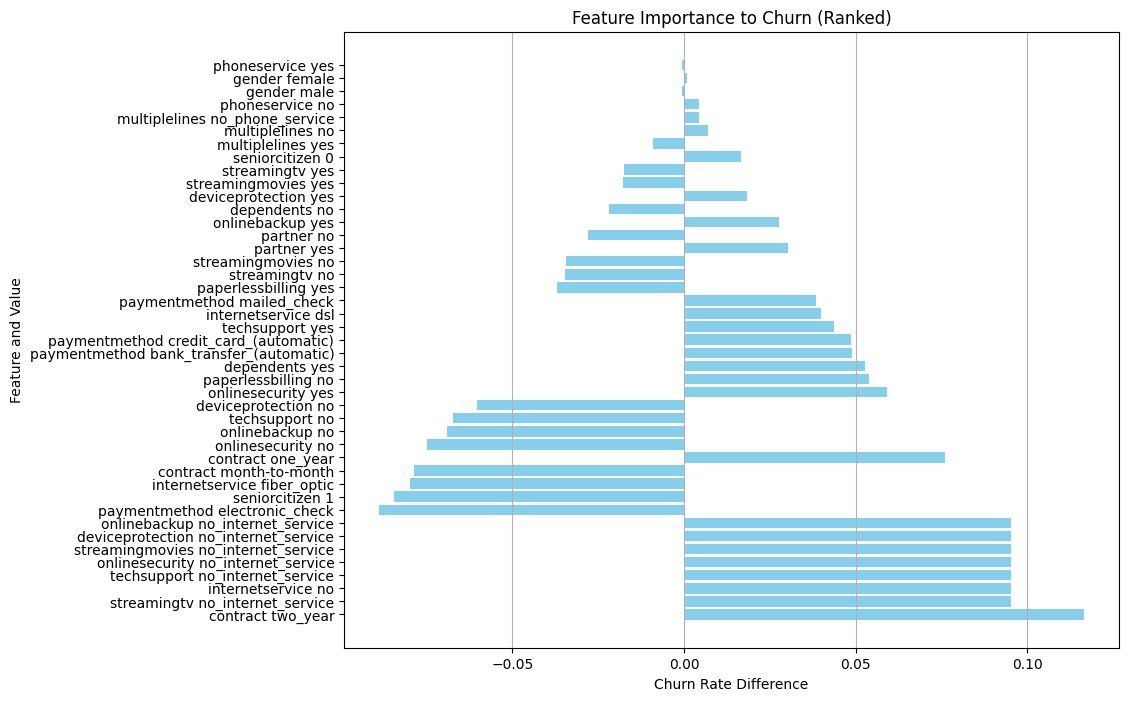

In [28]:
# Use a bar chart to represent the overall distribution of the variables based on feature-value
# Convert the churn rate differences dictionary into a DataFrame
churn_rate_df = pd.DataFrame(list(churn_rate_diff.items()), columns=['Feature_Value', 'Churn_Rate_Difference'])

# Split the 'Feature_Value' column into 'Feature' and 'Value'
churn_rate_df[['Feature', 'Value']] = churn_rate_df['Feature_Value'].str.split(' ', expand=True)

# Sort the DataFrame by the absolute value of churn rate differences in descending order
churn_rate_df['Abs_Churn_Rate_Difference'] = churn_rate_df['Churn_Rate_Difference'].abs()
churn_rate_df_sorted = churn_rate_df.sort_values(by='Abs_Churn_Rate_Difference', ascending=False)

# Create the bar graph
plt.figure(figsize=(10, 8))
plt.barh(churn_rate_df_sorted['Feature_Value'], churn_rate_df_sorted['Churn_Rate_Difference'], color='skyblue')
plt.xlabel("Churn Rate Difference")
plt.ylabel("Feature and Value")
plt.title("Feature Importance to Churn (Ranked)")
plt.grid(axis='x')
plt.show()







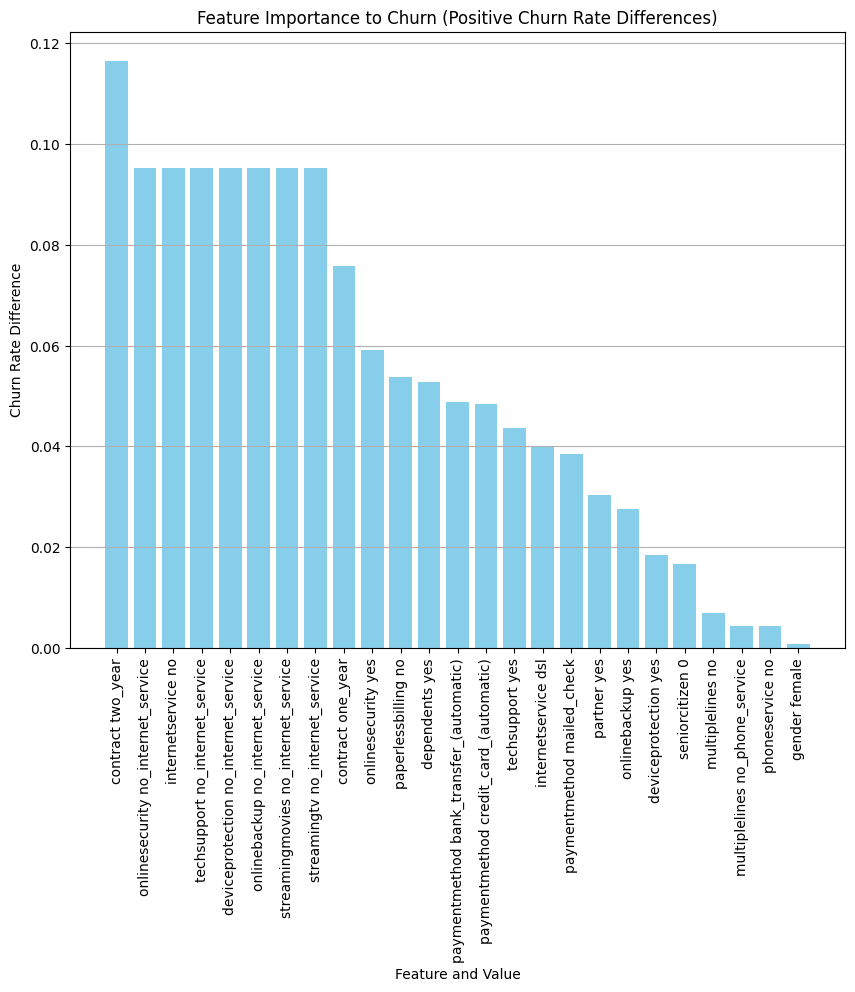

In [29]:
# Use a colum  chart to show the only the variables with positive feature-values
# Split the 'Feature_Value' column into 'Feature' and 'Value'
churn_rate_df[['Feature', 'Value']] = churn_rate_df['Feature_Value'].str.split(' ', expand=True)

# Filter out only the positive churn rate differences
positive_churn_rate_df = churn_rate_df[churn_rate_df['Churn_Rate_Difference'] > 0]

# Sort the DataFrame by the churn rate differences in descending order
positive_churn_rate_df_sorted = positive_churn_rate_df.sort_values(by='Churn_Rate_Difference', ascending=False)

# Create the column chart
plt.figure(figsize=(10, 8))
plt.bar(positive_churn_rate_df_sorted['Feature_Value'], positive_churn_rate_df_sorted['Churn_Rate_Difference'], color='skyblue')
plt.xlabel("Feature and Value")
plt.ylabel("Churn Rate Difference")
plt.title("Feature Importance to Churn (Positive Churn Rate Differences)")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


In [30]:
# Using the concept of mutual information from information theory to further understand feature importance
from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    return mutual_info_score(series, df.churn)

df_mi = df[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi

,MI
contract,0.038754
onlinesecurity,0.026143
internetservice,0.023680
techsupport,0.021872
onlinebackup,0.019866
deviceprotection,0.017569
paymentmethod,0.016052
streamingtv,0.013302
streamingmovies,0.013288
paperlessbilling,0.008853


In [36]:
df[numerical]

,tenure,monthlycharges,totalcharges
0,12,84.45,0
1,9,20.40,0
2,27,81.70,0
3,27,79.50,0
4,1,89.15,0
...,...,...,...
2038,24,84.80,1990.5
2039,72,103.20,7362.9
2040,11,29.60,346.45
2041,4,74.40,306.6


In [37]:
# We now start with the numeral variables/columns

# We use the concept of correlation coefficient to understand feature importance

df[numerical].corrwith(df.churn)

tenure           -0.223157
monthlycharges    0.127717
dtype: float64

###### With regards to the feature importance exploration above, it can be observed that contract, monthly charges, online security, internet service and up to streaming movies show a greater importance to classification of churn than the rest of the features.

In [38]:
# Convert categorical variables to numerial using one-hot encoding utilizing Dictvectorizer

df_to_dict = df[categorical + numerical].to_dict(orient='records')

from sklearn.feature_extraction import DictVectorizer

dv_df = DictVectorizer(sparse=False)
dv_df.fit(df_to_dict)

DictVectorizer(sparse=False)

In [39]:
# Now then transform our encoded features into a matrix,
X_df_to_dict = dv_df.transform(df_to_dict)

X_df_to_dict

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [40]:
# Data Splitting


# Separate the target variable 'churn' from the features
X = df.drop('churn', axis=1)
y = df['churn']

# Split the data into training, validation, and test sets
# The data will be split into 80% training, 10% validation, and 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Print the sizes of each split
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 3234
Validation set size: 404
Test set size: 405
